In [1]:
from utils import METRICS, MODEL_SIZES, sort_and_filter_metrics, CHECKPOINT_STEPS, get_checkpoint_evals, basic_data_sanity_check

import pickle 
import numpy as np
import plotnine as pn
import pandas as pd
import srsly
from pathlib import Path
from transformers import AutoConfig

/home/bmg44/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
basic_data_sanity_check()

def compute_explained_variance(S):
    """ For a matrix of singular values, compute the explained variance."""
    variances = S**2 / S.numel()
    explained_variances = variances / np.sum(variances)
    return explained_variances

def compute_condition_number(S, matrix_rank=None):
    """ For a matrix of singular values, compute the condition number."""
    if matrix_rank is None:
        matrix_rank = len(S)
    return S[0] / S[matrix_rank - 1]

def compute_effective_rank(S, matrix_rank):
    """ Compute the effective rank of a matrix as defined by the entropy of the standardized eigenvalues"""
    limited_S = S[:matrix_rank]
    # stand_S = limited_S / limited_S[0]
    stand_S = limited_S / np.linalg.norm(limited_S, ord=1) # Standardize the singular values
    # stand_S = limited_S / np.sum(limited_S) # Standardize the singular values
    return np.exp(-np.sum(stand_S * np.log(stand_S)))/len(stand_S)

In [3]:
data = []
svd_data = {"weight": [], "grad_weight": []}

CIRCUITS = {"mlp": "dense_4h_to_h", "attention": "ov_circuit"}
for model_size in MODEL_SIZES:
    # checkpoint_evals = get_checkpoint_evals(model_size)
    model_config = AutoConfig.from_pretrained(f"/home/bmg44/gpt-neox/hf-checkpoints-14m-2-qk-layernorm")

    # load svd
    for k in svd_data.keys():
        

        with open(f'/home/bmg44/pretraining-playground/computed-statistics-qk-layernorm/{model_size}/{k}_svd_per_layer.pkl', 'rb') as f:
            svd_weights = pickle.load(f)
        
        for circuit_name, circuit_layer in CIRCUITS.items():
            circuit_svd = sort_and_filter_metrics(svd_weights, filter_layer_name=circuit_layer)

            for layer_name, layer_sv in circuit_svd.items():

                i = layer_name.split(".")[2]

                # Iterating over all of the layers 
                matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

                # Effective ranks for a given layer over the course of all checkpoints
                effective_ranks = [compute_effective_rank(checkpoint_layer_sv, matrix_rank=matrix_rank) for checkpoint_layer_sv in layer_sv]

                svd_data[k].append((circuit_name, model_size, CHECKPOINT_STEPS, i, layer_name, matrix_rank, effective_ranks))

    # load metrics
    for metric_name in METRICS:
        with open(f'/home/bmg44/pretraining-playground/computed-statistics-qk-layernorm/{model_size}/{metric_name}_per_layer.pkl', 'rb') as f:
            all_metrics = pickle.load(f)

        for circuit_name, circuit_layer in CIRCUITS.items():
            circuit_metrics = sort_and_filter_metrics(all_metrics, filter_layer_name=circuit_layer, remove_heads=True)
            
            for i, (layer_name, layer_metric) in enumerate(circuit_metrics.items()):
                if metric_name == "grad_weight_magnitudes":
                    layer_metric = np.log(layer_metric)
                data.append((metric_name, circuit_name, model_size, CHECKPOINT_STEPS, i, layer_name, layer_metric))

svd_weight_df = pd.DataFrame(svd_data["weight"], columns=["circuit", "model_size", "checkpoint_idx", "layer_idx", "layer", "rank", "effective_rank"])
svd_grad_df = pd.DataFrame(svd_data["grad_weight"], columns=["circuit", "model_size", "checkpoint_idx", "layer_idx", "layer", "rank", "effective_rank"])
df = pd.DataFrame(data, columns=["metric", "circuit", "model_size", "checkpoint_idx", "layer_idx", "layer", "value"])
print(df)

                    metric    circuit model_size  \
0               cka_scores        mlp        14m   
1               cka_scores        mlp        14m   
2               cka_scores        mlp        14m   
3               cka_scores        mlp        14m   
4               cka_scores        mlp        14m   
5               cka_scores        mlp        14m   
6               cka_scores  attention        14m   
7               cka_scores  attention        14m   
8               cka_scores  attention        14m   
9               cka_scores  attention        14m   
10              cka_scores  attention        14m   
11              cka_scores  attention        14m   
12                grad_sim        mlp        14m   
13                grad_sim        mlp        14m   
14                grad_sim        mlp        14m   
15                grad_sim        mlp        14m   
16                grad_sim        mlp        14m   
17                grad_sim        mlp        14m   
18          

In [4]:
cmap = dict(zip(["14M"], ["#003049"]))

def process_dataframe(df: pd.DataFrame, explode_col: str) -> pd.DataFrame:
    def as_cat(x: pd.Series) -> pd.Categorical:
        return pd.Categorical(x.tolist(), categories=list(cmap.keys()))

    df = df.explode(["checkpoint_idx", explode_col])
    df = df.convert_dtypes()
    df = df.assign(model_size=lambda _df: as_cat(_df["model_size"].str.upper()))
    return df

df = process_dataframe(df, "value")
svd_weight_df = process_dataframe(svd_weight_df, "effective_rank")
svd_grad_df = process_dataframe(svd_grad_df, "effective_rank")

CKA Initial plot

In [5]:
pdata = (
    df
    .query("metric == 'cka_scores'")
    # for clarity keep only certain checkpoints
    .assign(
        model_size=lambda _df: _df["model_size"].astype(str),
        circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
        value=lambda _df: _df["value"].astype(float),
    )
)

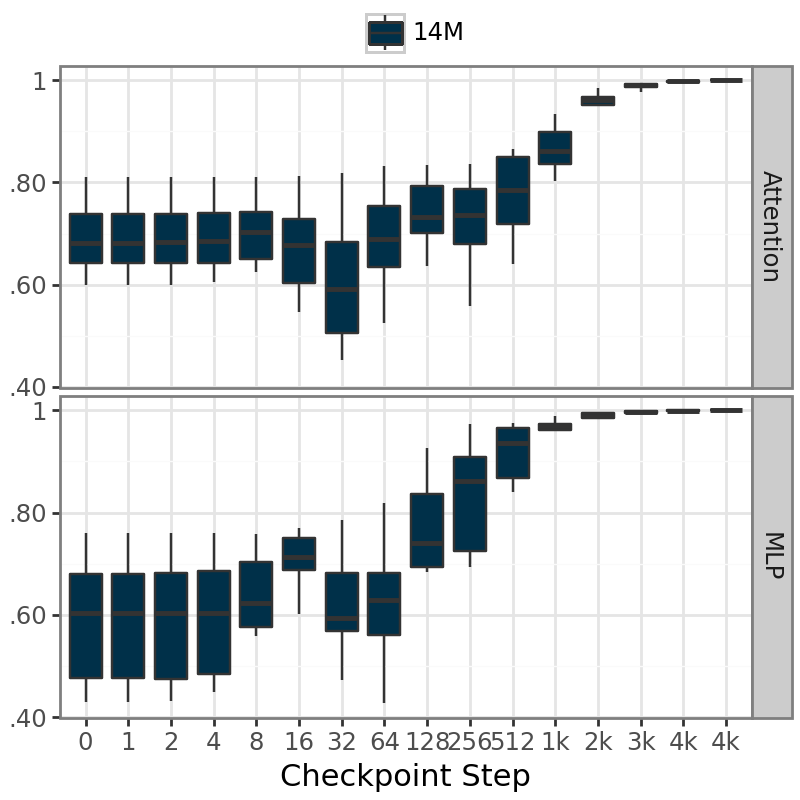

/home/bmg44/anaconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 4 in image.
/home/bmg44/anaconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../plots/cka_main_plot.pdf


FileNotFoundError: [Errno 2] No such file or directory: '../plots/cka_main_plot.pdf'

In [6]:

p = (
    pn.ggplot(pdata, pn.aes("factor(checkpoint_idx)", "value", fill="model_size")) +
    pn.geom_boxplot(position="dodge", outlier_alpha=0) +
    pn.facet_grid(rows="circuit") +
    pn.scale_x_discrete(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(labels=lambda x: ["." + f"{v:.2f}".split(".")[1] if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
    pn.scale_fill_manual(values=cmap) +
    pn.labs(x="Checkpoint Step", y="", fill="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.01, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(4, 4), legend_position="top")
)
p.show()
p.save("../plots/cka_main_plot.pdf")

CKA all plots

In [ ]:
pdata = (
    df
    .query("metric == 'cka_scores'")
    # for clarity keep only certain checkpoints
    .assign(
        circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
        value=lambda _df: _df["value"].astype(float),
    )
)

In [ ]:
colours = [
    "#1f77b4"
]
cmap_long = dict(zip(range(len(colours)), colours))

In [ ]:
p = (
    pn.ggplot(pdata, pn.aes("checkpoint_idx", "value", colour="factor(layer_idx)")) +
    pn.geom_point() +
    pn.geom_line() +
    # pn.facet_grid(cols="circuit") +
    pn.facet_grid(rows="model_size", cols="circuit") +
    pn.scale_x_sqrt(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(labels=lambda x: ["." + f"{v:.2f}".split(".")[1] if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
    pn.scale_colour_hue() +
    # pn.scale_colour_cmap_d("spectral") +
    # pn.scale_colour_cmap_d("plasma") +
    # pn.scale_color_distiller(type="diverging") +
    # pn.scale_colour_brewer(type="qualitative", palette=1) +
    # pn.scale_colour_manual(values=cmap_long) +
    pn.labs(x="Checkpoint Step", y="", colour="Layer") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(9, 4))
)
p.show()
p.save("../plots/cka_full_lines.pdf")

In [ ]:
p = (
    pn.ggplot(pdata.dropna(), pn.aes("factor(checkpoint_idx)", "layer_idx", fill="value")) +
    pn.geom_tile(height=1, colour="black") +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
    pn.scale_x_discrete(
        expand=(0, 0),
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.scale_fill_gradient2(
        limits=(0, 1), midpoint=.95, low="white", mid="green", high="black",
        labels=lambda x: ["." + f"{v:.2f}".split(".")[1] if v > 0 and v < 1 else str(int(v != 0)) for v in x],
    ) +
    pn.labs(fill="", x="Checkpoint Step", y="Layer ID") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/cka_full_heat.pdf")

In [7]:
pdata = (
    svd_weight_df
    # for clarity keep only certain checkpoints
    .assign(
        circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
        effective_rank=lambda _df: _df["effective_rank"].astype(float),
        layer_idx=lambda _df: _df["layer_idx"].astype(int),
    )
)

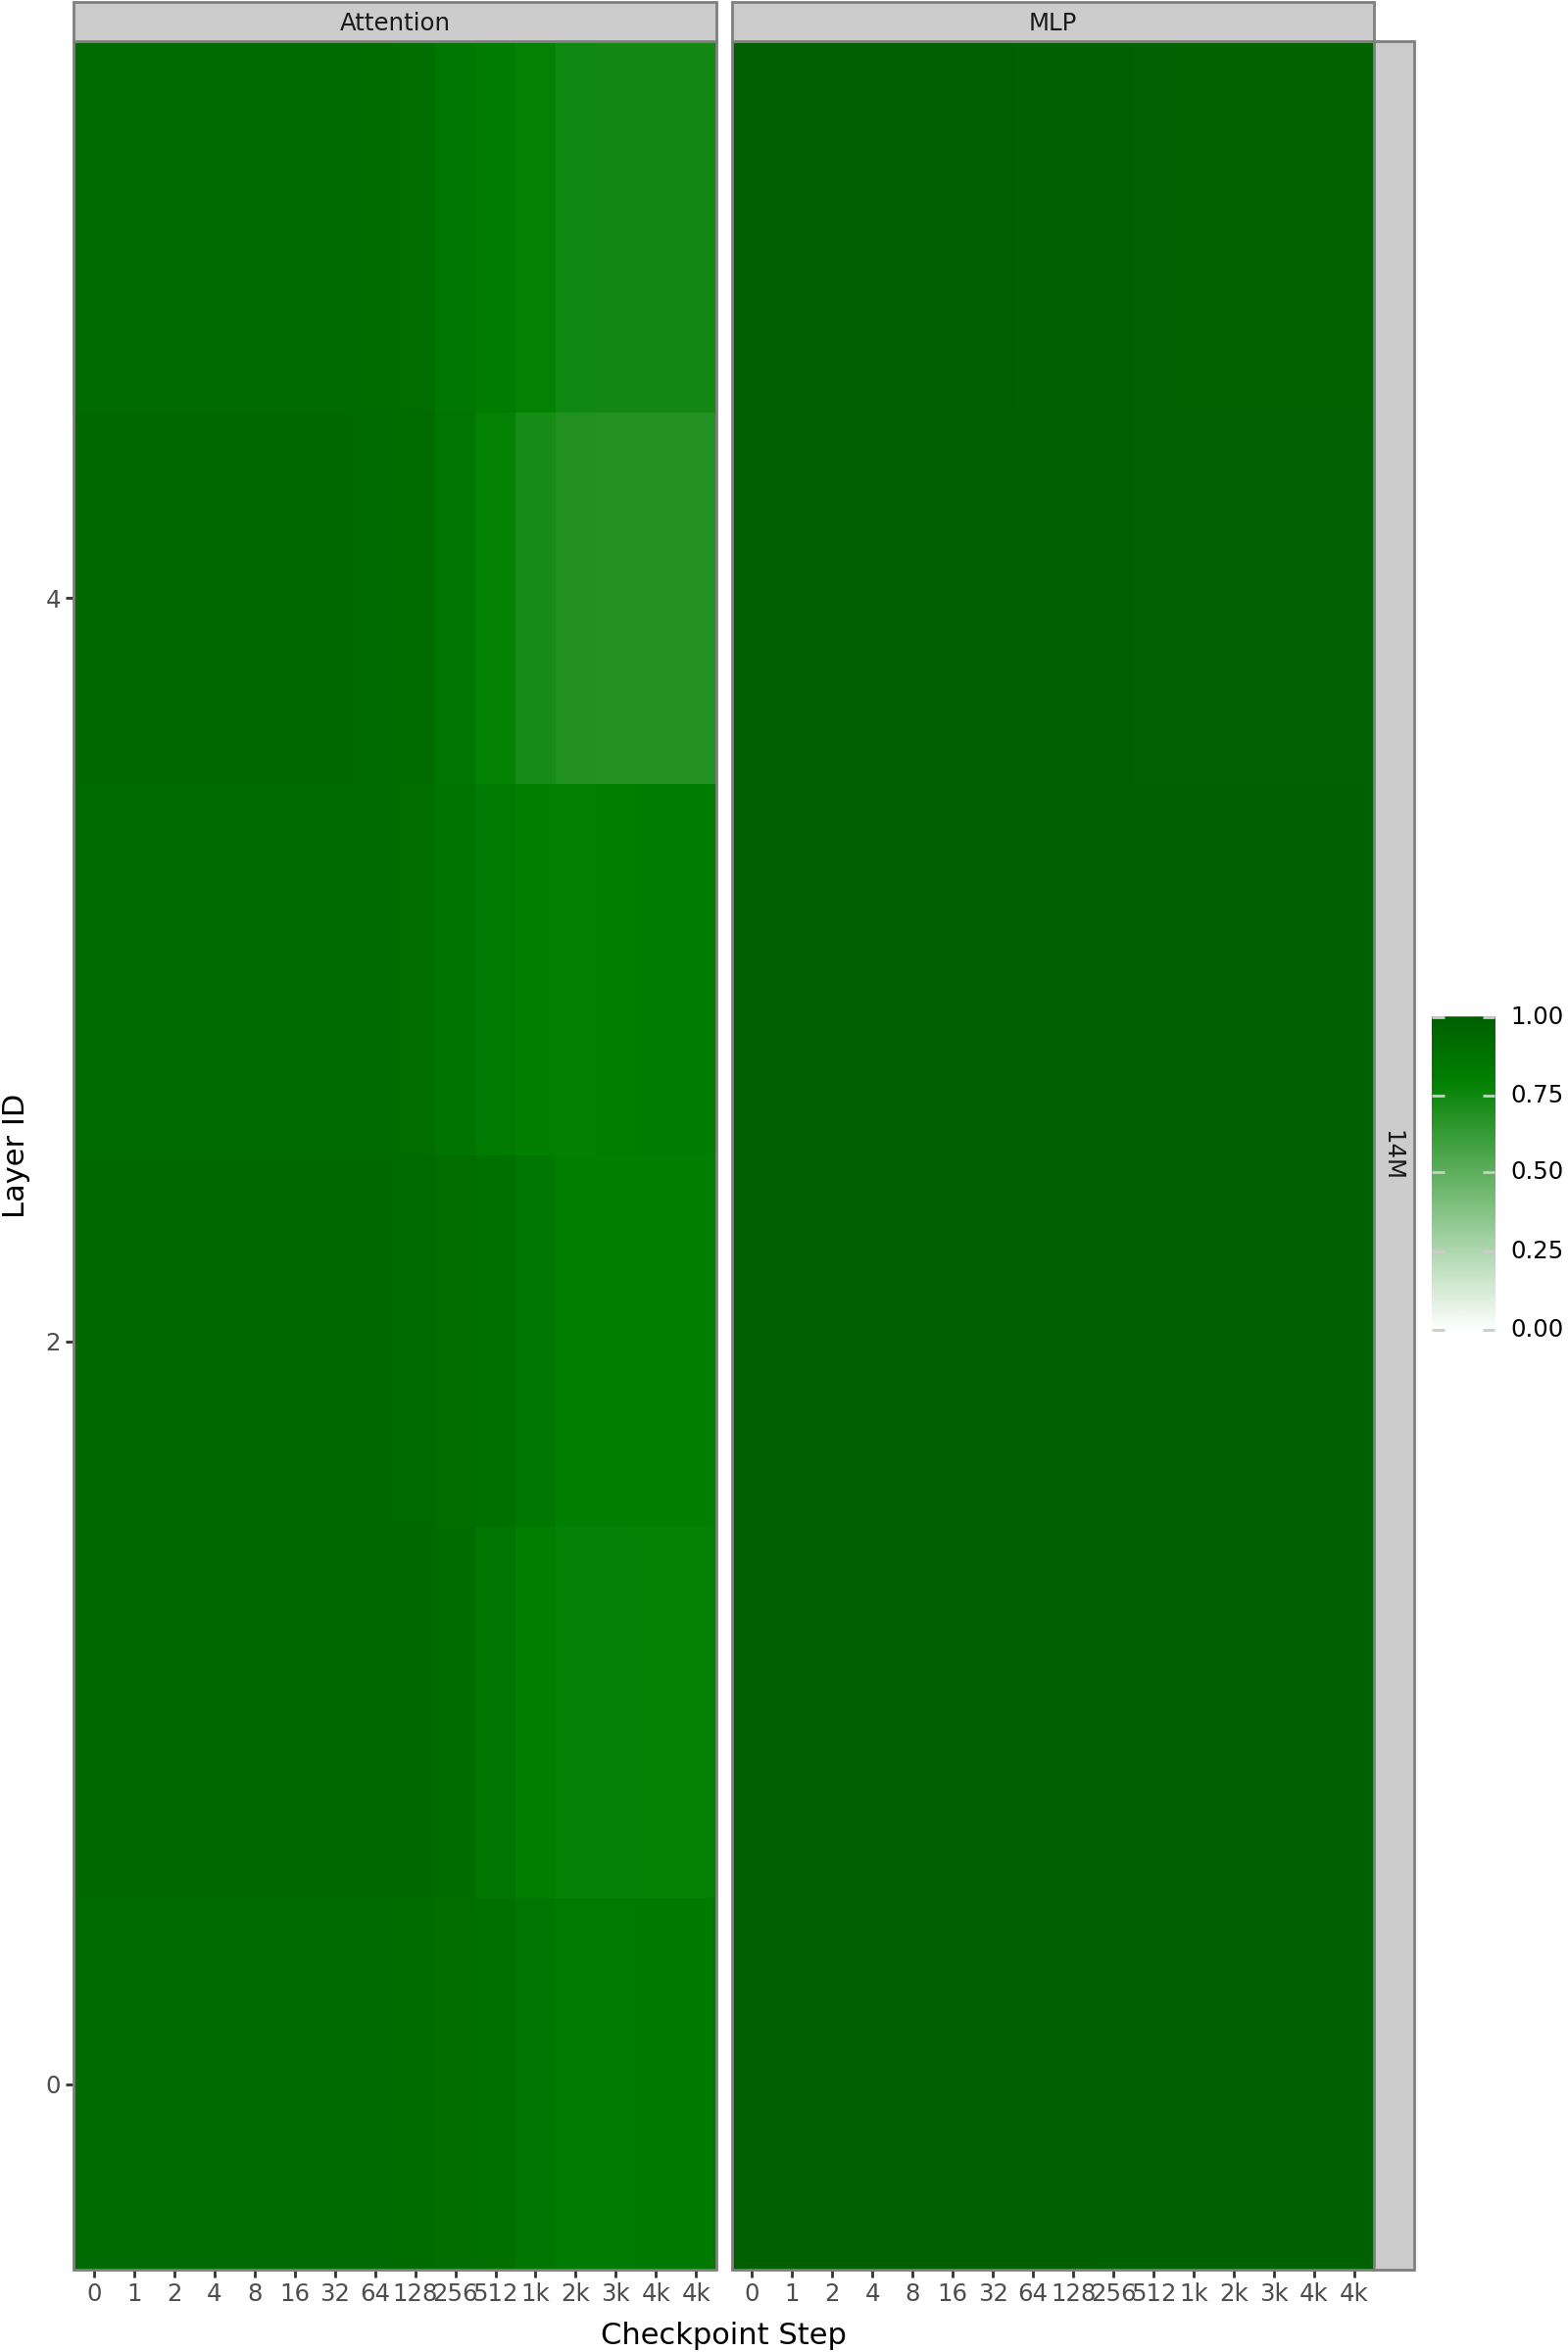

In [8]:
p = (
    pn.ggplot(pdata.dropna(), pn.aes("factor(checkpoint_idx)", "layer_idx", fill="effective_rank")) +
    pn.geom_tile(height=1, colour=None) +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
    pn.scale_x_discrete(
        expand=(0, 0),
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.scale_fill_gradient2(limits=(0, 1), midpoint=.8, low="white", mid="green", high="black") +
    pn.labs(fill="", x="Checkpoint Step", y="Layer ID") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
# p.save("../plots/cka_full_heat.pdf")

In [9]:
cols = ["metric", "circuit", "model_size", "checkpoint_idx", "layer_idx", "value"]
pdata = pd.concat(
    [
        (
            df
            .query("metric == 'cka_scores'")
            # for clarity keep only certain checkpoints
            .assign(
                circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
                value=lambda _df: _df["value"].astype(float),
                metric="cka",
            )
            [cols]
        ),
        (
            svd_weight_df
            .assign(
                circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
                value=lambda _df: _df["effective_rank"].astype(float),
                metric="per_weight",
            )
            [cols]
        ),
        (
            svd_grad_df
            .assign(
                circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}),
                value=lambda _df: _df["effective_rank"].astype(float),
                metric="per_grad",
            )
            [cols]
        )
    ],
    axis=0,
)
pdata

,metric,circuit,model_size,checkpoint_idx,layer_idx,value
0,cka,MLP,14M,0,0,0.760838
0,cka,MLP,14M,1,0,0.760838
0,cka,MLP,14M,2,0,0.760656
0,cka,MLP,14M,4,0,0.759826
0,cka,MLP,14M,8,0,0.757596
...,...,...,...,...,...,...
35,per_grad,Attention,14M,1000,5,0.189548
35,per_grad,Attention,14M,2000,5,0.199513
35,per_grad,Attention,14M,3000,5,0.198547
35,per_grad,Attention,14M,4000,5,0.193618


In [10]:
gcols = cols[:-2]
print(f"Grouping by: {gcols}")

metric_map = {"cka": "CKA", "per_weight": "PER (Weight)", "per_grad": "PER (Grad)"}

pdata = (
    pdata.groupby(gcols, observed=True)["value"]
    .agg(
        median=lambda x: x.median(),
        q75=lambda x: x.quantile(.75),
        q25=lambda x: x.quantile(.25),
        mean=lambda x: x.mean(),
        min=lambda x: x.min(),
    )
    .reset_index()
    .assign(
        metric=lambda _df: pd.Categorical(_df["metric"].map(metric_map), categories=list(metric_map.values()))
    )
)

Grouping by: ['metric', 'circuit', 'model_size', 'checkpoint_idx']


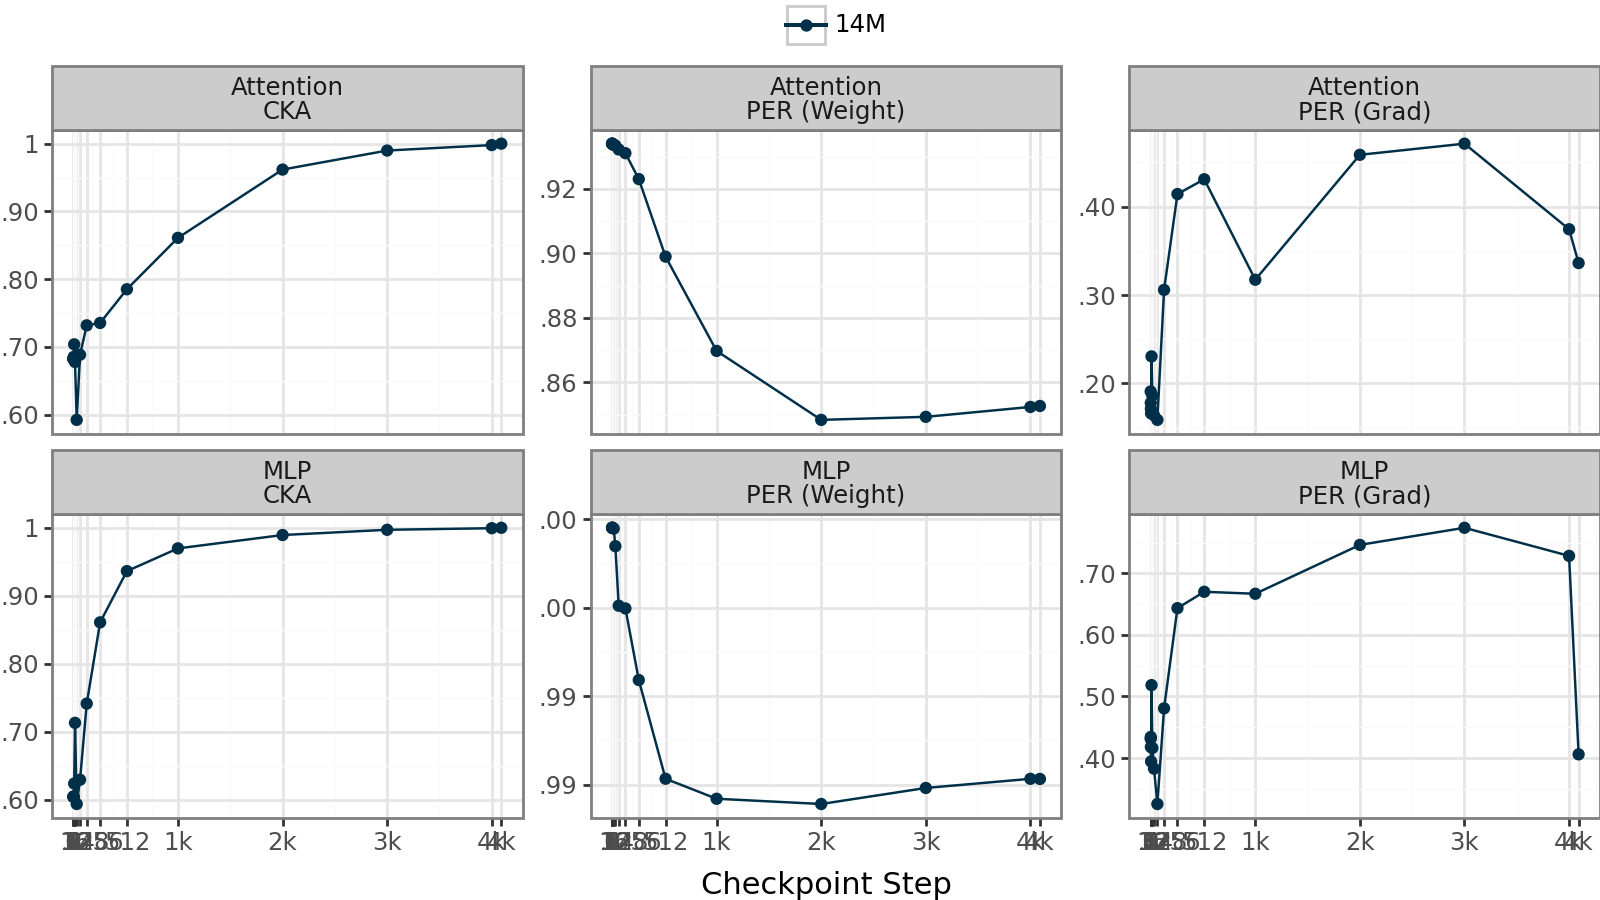

/home/bmg44/anaconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.5 in image.
/home/bmg44/anaconda3/envs/py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../plots/results.pdf


FileNotFoundError: [Errno 2] No such file or directory: '../plots/results.pdf'

In [11]:
p = (
    pn.ggplot(
        pdata.query("(metric != 'PER (Grad)') | ((metric == 'PER (Grad)') & (median > 0))"), 
        pn.aes("checkpoint_idx", "median", colour="model_size") #ymin="q25", ymax="q75")
    ) +
    pn.geom_line() +
    pn.geom_point() +
    pn.facet_wrap(["circuit", "metric"], scales="free_y") +
    pn.scale_x_continuous(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(labels=lambda x: ["." + f"{v:.2f}".split(".")[1] if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
    pn.scale_colour_manual(values=cmap) +
    pn.labs(x="Checkpoint Step", y="", colour="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0., plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 4.5), legend_position="top")
)
p.show()
p.save("../plots/results.pdf")

In [ ]:
# p1 = (
#     pn.ggplot(
#         pdata, 
#         pn.aes("checkpoint_idx", "median", colour="model_size") #ymin="q25", ymax="q75")
#     ) +
#     pn.geom_line() +
#     pn.geom_point() +
#     pn.facet_grid(cols="circuit", rows="metric", scales="free") +
#     pn.scale_x_continuous(
#         breaks=[0, 13000, 43000, 93000, 143000],
#         labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
#     ) +
#     pn.scale_y_continuous(labels=lambda x: [f"{v:.2f}" if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
#     pn.scale_colour_manual(values=cmap) +
#     pn.labs(x="Checkpoint Step", y="", colour="") +
#     pn.theme_bw(base_size=11) +
#     pn.theme(plot_margin=0.01, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 4.5), legend_position="top")
# )
# p1.show()

In [74]:
# p1 = (
#     pn.ggplot(
#         pdata, 
#         pn.aes("checkpoint_idx", "median", colour="model_size") #ymin="q25", ymax="q75")
#     ) +
#     pn.geom_line() +
#     pn.geom_point() +
#     pn.facet_grid(rows="circuit", cols="metric", scales="free") +
#     pn.scale_x_continuous(
#         breaks=[0, 13000, 43000, 93000, 143000],
#         labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
#     ) +
#     pn.scale_y_continuous(labels=lambda x: [f"{v:.2f}" if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
#     pn.scale_colour_manual(values=cmap) +
#     pn.labs(x="Checkpoint Step", y="", colour="") +
#     pn.theme_bw(base_size=11) +
#     pn.theme(plot_margin=0.01, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 4.5), legend_position="top")
# )
# p1.show()

In [35]:
p = (
    pn.ggplot(pdata, pn.aes("factor(checkpoint_idx)", "value", fill="model_size")) +
    pn.geom_boxplot() +
    # pn.coord_flip() +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_x") +
    pn.scale_x_discrete(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_y_continuous(labels=lambda x: [f"{v:.2f}" if v > 0 and v < 1 else str(int(v != 0)) for v in x]) +
    pn.scale_fill_manual(cmap, guide=None) +
    pn.labs(x="Checkpoint Step", y="CKA", fill="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/cka_across_layers.pdf")

PlotnineError: "Could not evaluate the 'y' mapping: 'value' (original error: name 'value' is not defined)"

Proportional Effective Rank

In [36]:
pdata = (
    svd_weight_df
    # for clarity keep only certain checkpoints
    .assign(circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}))
)

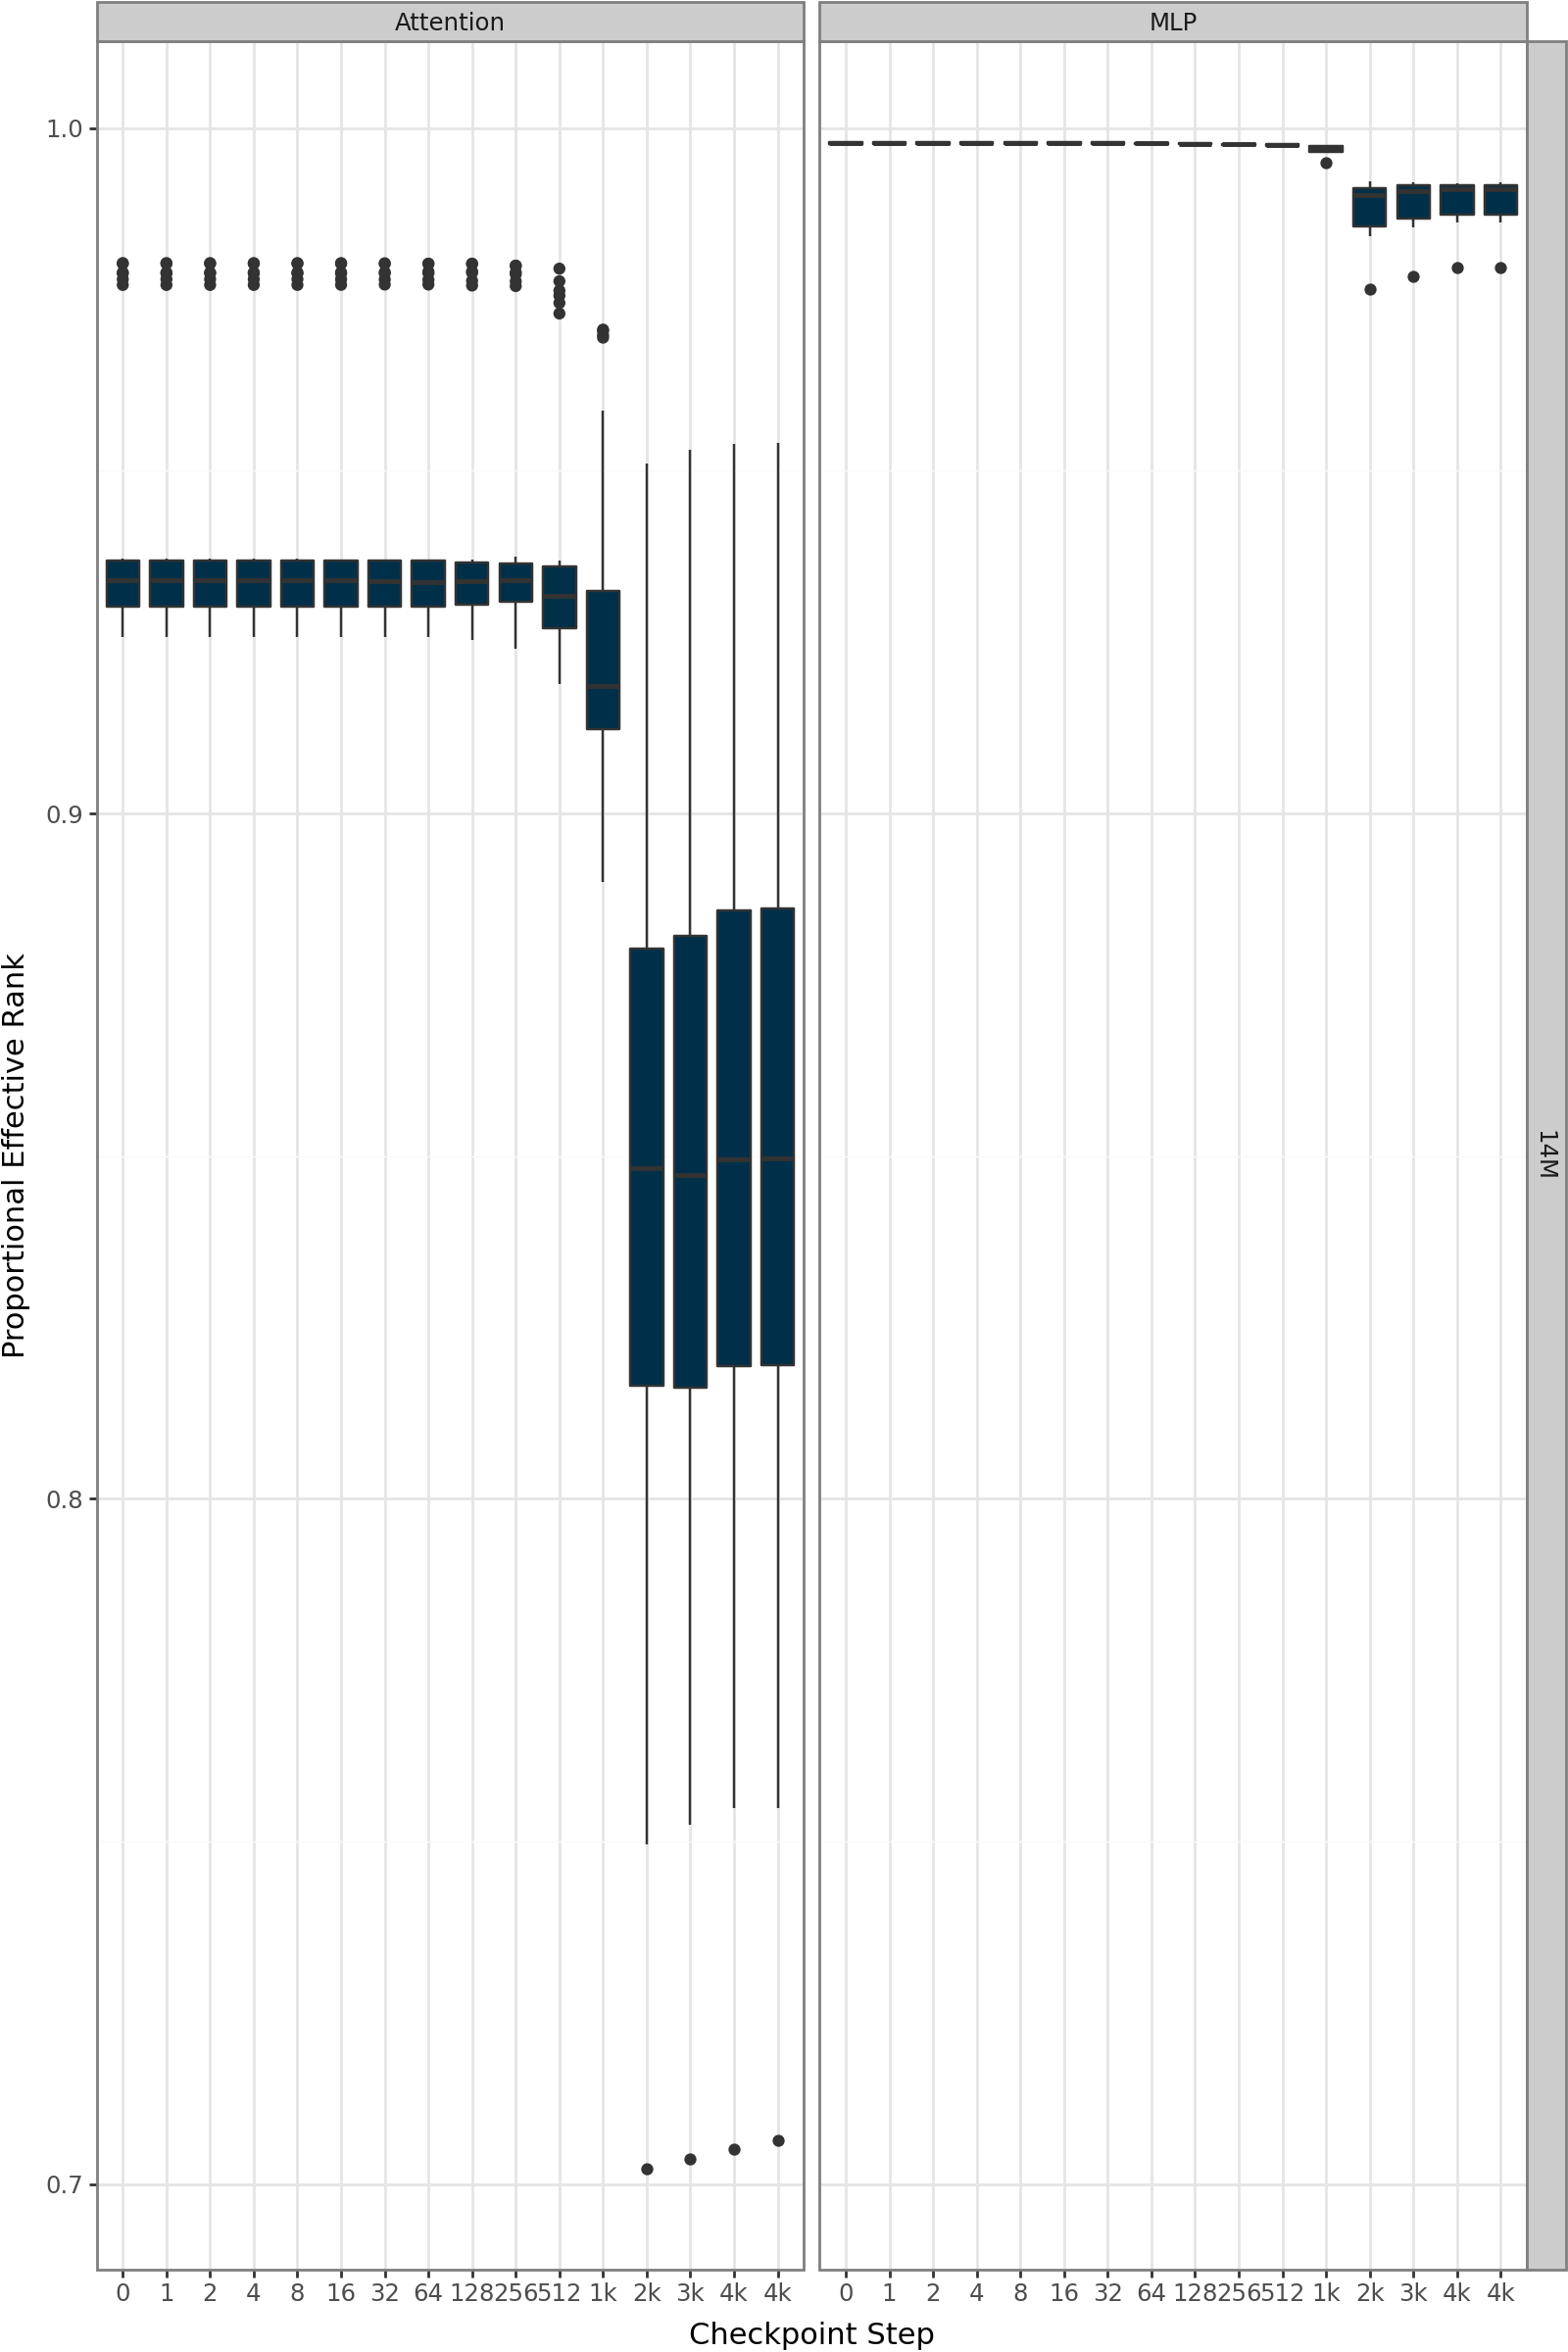

/home/bmg44/anaconda3/envs/new_py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 12 in image.
/home/bmg44/anaconda3/envs/new_py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../plots/per_weights_across_layers.pdf


FileNotFoundError: [Errno 2] No such file or directory: '../plots/per_weights_across_layers.pdf'

In [37]:
p = (
    pn.ggplot(pdata, pn.aes("factor(checkpoint_idx)", "effective_rank", fill="model_size")) +
    pn.geom_boxplot() +
    # pn.coord_flip() +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
    pn.scale_x_discrete(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_fill_manual(cmap, guide=None) +
    pn.labs(x="Checkpoint Step", colour="Layer", y="Proportional Effective Rank", fill="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/per_weights_across_layers.pdf")

In [38]:
pdata = (
    svd_grad_df
    # for clarity keep only certain checkpoints
    .assign(circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}))
)

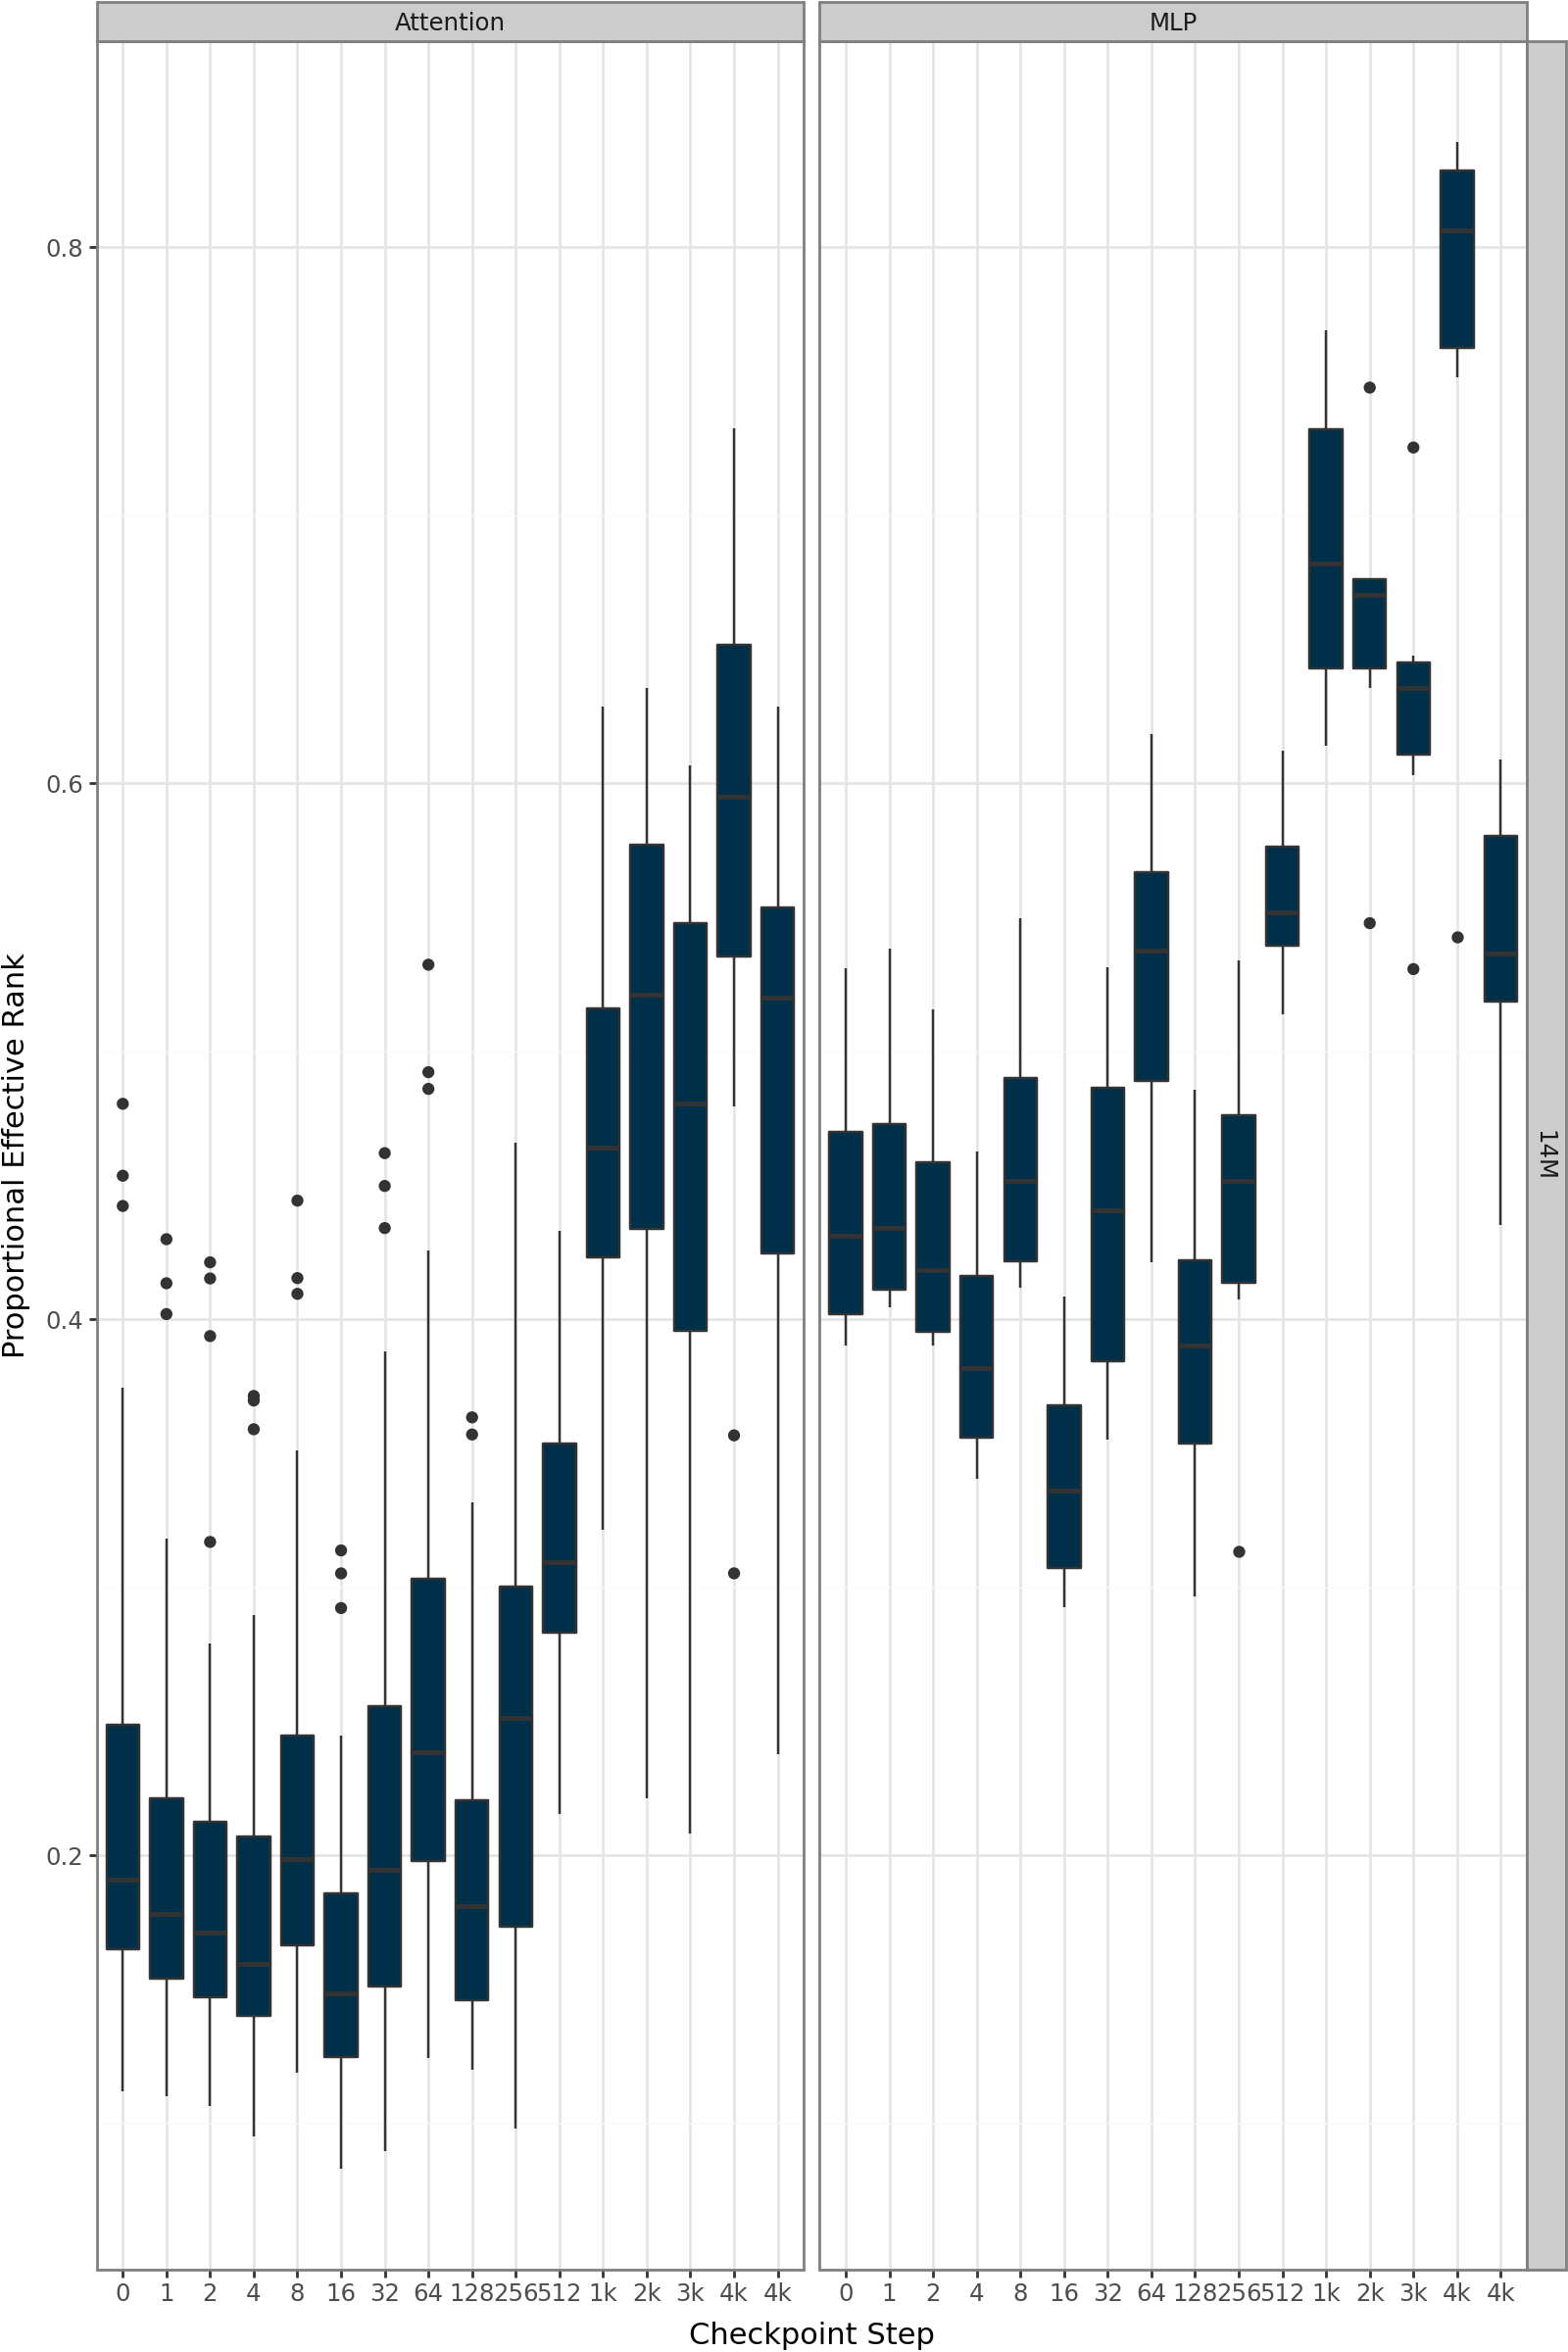

/home/bmg44/anaconda3/envs/new_py310/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 12 in image.
/home/bmg44/anaconda3/envs/new_py310/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../plots/per_grads_across_layers.pdf


FileNotFoundError: [Errno 2] No such file or directory: '../plots/per_grads_across_layers.pdf'

In [39]:
p = (
    pn.ggplot(pdata, pn.aes("factor(checkpoint_idx)", "effective_rank", fill="model_size")) +
    pn.geom_boxplot() +
    # pn.coord_flip() +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
    pn.scale_x_discrete(
        breaks=[0, 1,2, 4 ,8 ,16, 32, 64, 128, 256, 512, 1000, 2000, 3000, 4000, 4091],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_fill_manual(cmap, guide=None) +
    pn.labs(x="Checkpoint Step", colour="Layer", y="Proportional Effective Rank", fill="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/per_grads_across_layers.pdf")

In [15]:
# Heatmap of median
# pdata = (
#     svd_weight_df
#     # for clarity keep only certain checkpoints
#     .query("(checkpoint_idx.isin([0, 1000, 3000])) | (checkpoint_idx >= 10000)")
#     .assign(
#         circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}), 
#         layer_idx=lambda _df: _df["layer_idx"].astype(int),
#         checkpoint_idx=lambda _df: pd.Categorical(_df["checkpoint_idx"].tolist(), categories=sorted(_df["checkpoint_idx"].unique().tolist()))
#     )
#     .groupby(["model_size", "checkpoint_idx", "layer_idx", "circuit"])["effective_rank"].median()
#     .reset_index()
# )
# p = (
#     pn.ggplot(pdata.dropna(), pn.aes("factor(checkpoint_idx)", "layer_idx", fill="effective_rank")) +
#     pn.geom_tile(height=1, colour=None) +
#     pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
#     pn.scale_x_discrete(
#         expand=(0, 0),
#         breaks=[0, 1000, 3000, 13000, 43000, 93000, 143000],
#         labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
#     ) +
#     pn.scale_y_continuous(expand=(0, 0)) +
#     pn.scale_fill_gradient2(limits=(.7, 1.), midpoint=.8, low="black", mid="green", high="white") +
#     pn.labs(fill="", x="Checkpoint Step", y="Layer ID") +
#     pn.theme_bw(base_size=11) +
#     pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
# )
# p.show()
# # p.save("../plots/median_effective_rank.pdf")

----

In [16]:
# data_path = Path("../pythia/evals/pythia-v1/")

# data = []
# for p in data_path.rglob("pythia-*-deduped/zero-shot/*.json"):
#     ckpt = int(p.name.split("_step")[-1].removesuffix(".json"))
#     model_size = p.name.split("-")[0].upper()
#     acc = srsly.read_json(p)["results"]["lambada_openai"]["acc"]
#     acc_stderr = srsly.read_json(p)["results"]["lambada_openai"]["acc_stderr"]
#     data.append((model_size, ckpt, acc, acc_stderr))

# eval_df = pd.DataFrame(data, columns=["model_size", "checkpoint_idx", "acc", "acc_stderr"])
# eval_df = eval_df.convert_dtypes()